##### VGG
- 卷积层+RELU
（3x3卷积，2层3x3卷积，一个感受野=5x5）
- 最大池化层
- 全连接+RELU
- softmax
#### 网络结构22333

<img src="https://s1.ax1x.com/2022/11/04/xL2T56.jpg" width = 60% height = 60% />
<img src="https://s1.ax1x.com/2022/11/04/xLRSat.jpg" width = 90% height = 90% />


loss 0.048, train acc 0.982, test acc 0.932
996.1 examples/sec on cuda:0


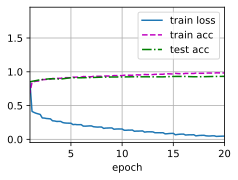

In [43]:
import d2l.torch
import torch
from torch import nn

def vgg_block(nums_conv2d,in_channels,out_channels):
    blocks = []
    for _ in range(nums_conv2d):
        blocks.append(nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=3,padding=1))
        blocks.append(nn.ReLU())
        in_channels = out_channels
    blocks.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*blocks)

def vgg(conv2d_arch):
    VGG_blocks = []
    in_channels = 1
    #for循环来添加每个卷积块，卷积层模块
    for nums_conv2d,out_channels in conv2d_arch:
        VGG_blocks.append(vgg_block(nums_conv2d=nums_conv2d,in_channels=in_channels,out_channels=out_channels))
        in_channels = out_channels #下一层卷积层输入channels数为上一层卷积层输出channels
    return nn.Sequential(*VGG_blocks,
                         nn.Flatten(),
                         # 全连接层模块则与AlexNet中的相同。in_channels数为最后一层卷积层的输出channels（然后赋值给in_channels，在for循环里面赋值进行的，作为下一层Flatten层的输入，铺平展开后，输入到全连接层，因此全连接层输入in_features=in_channels*7*7）
                         nn.Linear(in_features=in_channels*7*7,out_features=4096),#7*7是因为输入尺寸是224*224，经过每个卷积块后尺寸都会除以2，经过五个卷积块后，则输出尺寸大小为224*2*2*2*2*2=7
                         nn.ReLU(),
                         nn.Dropout(0.5),
                         nn.Linear(in_features=4096,out_features=4096),
                         nn.ReLU(),
                         nn.Dropout(),
                         nn.Linear(in_features=4096,out_features=10))
X = torch.randn(size=(1,1,224,224))
#conv2d_arch含有五个VGG块，指定了每个VGG块里卷积层个数和输出通道数，为一个超参数
conv2d_arch = ((1,64),(1,128),(2,256),(2,512),(2,512))
ratio = 4
small_conv2d_arch = ((pair[0],pair[1] // ratio) for pair in conv2d_arch)#由于VGG-11比AlexNet计算量更大，因此我们构建了一个通道数较少的网络，足够用于训练Fashion-MNIST数据集。
VGGNet = vgg(small_conv2d_arch)
#构建一个高度和宽度为224的单通道数据样本X，来观察每个层输出的形状
for layer in VGGNet:
    X = layer(X)
    print(layer.__class__.__name__,'output shape : \t',X.shape)
lr,num_epochs,batch_size = 0.05,20,100 #除了使用比AlexNet略高的学习率外，模型训练过程与 AlexNet类似
train_iter,test_iter = d2l.torch.load_data_fashion_mnist(batch_size=batch_size,resize=224)
#调用d2l里面封装好的训练模型函数，这个训练函数跟前面LeNet里面训练模型函数一模一样
d2l.torch.train_ch6(VGGNet,train_iter=train_iter,test_iter=test_iter,num_epochs=num_epochs,lr=lr,device=d2l.torch.try_gpu())
